In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
import os
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
tf.get_logger().setLevel('INFO')
import tensorflow_probability as tfp

from transport_nets.bijectors.banana_map import BananaMap, BananaFlow
from transport_nets.Models.NVP import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

## Training the Model

First, we set up the normalizing flow so that it will save once every 5 epochs. In the next sections we will show how to load the saved model.

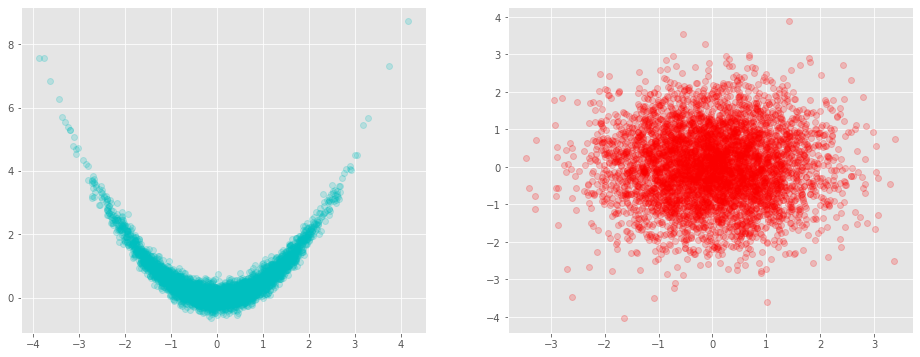

In [2]:
# Draw samples from both the target and the reference/latent space
num_samples = 5000
bMap = BananaMap((1.0,0.5,0.2,0.0))
bFlow = BananaFlow(bMap)
target = bFlow.sample(num_samples)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object and optimizer
def CreateModel(optimizer, latent_samples):
    nvp = NVP(num_layers=4, neuron_list=[75,75])
    nvp.compile(optimizer)
    # Perform a forward pass to initialize variables
    _ = nvp(latent)
    nvp.batch_norm_mode(False)
    return nvp

opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)

nvp = CreateModel(opt, latent)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [4]:
# Setup checkpoints
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

In [5]:
# Define training options
n_epochs = 125
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
nvp.fit(dataset, epochs=n_epochs, callbacks=[cp_callback])  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/125
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 2.2735
Epoch 2/125
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 2.0818
Epoch 3/125
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 1.9439
Epoch 4/125
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: 1.8333
Epoch 5/125
 90/100 [==========================>...] - ETA: 0s - Negative Log Likelihood: 1.7149
Epoch 00005: saving model to training_1/cp.ckpt
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 1.7367
Epoch 6/125
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 1.6501
Epoch 7/125
100/100 [==============================] - 0s 3ms/step - Negative Log Likelihood: 1.5626
Epoch 8/125
100/100 [==============================] - 0s 4ms/step - Negative Log Likelihood: 1.4814
Epoch 9/125
100/100 [==============================] - 0s 4

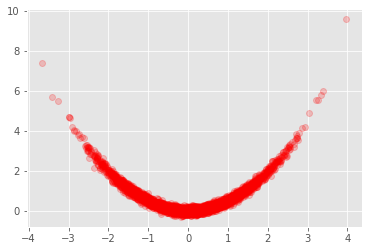

In [6]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)

## Loading the Saved Model Parameters
Now, we demonstrate how to load the saved model parameters.

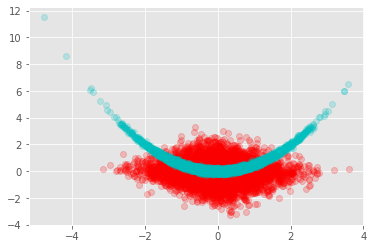

In [7]:
# Create new model object to load the data into 
unsaved_nvp = CreateModel(opt, latent)

# First, show that it is untrained
forward_pass = unsaved_nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

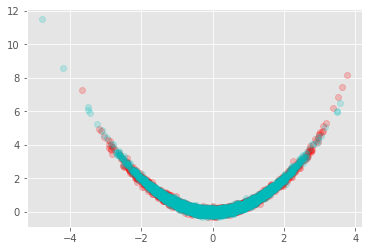

In [8]:
# Now, load the weights
unsaved_nvp.load_weights(checkpoint_path)

# It should be trained
forward_pass = unsaved_nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Saving and Loading the Model Itself
Now, we demonstrate how to load the saved model.

In [9]:
# Save the model
nvp.save('saved_model/my_model') 

Instructions for updating:
Do not call `graph_parents`.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


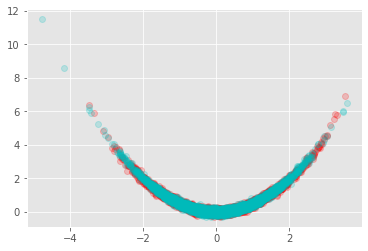

In [10]:
# Load the new model
new_nvp = tf.keras.models.load_model('saved_model/my_model')
forward_pass = new_nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)